# Imports

In [1]:
import torch
import torch.nn as nn  # All neural network modules, nn.linear, nn.conv2d, BatchNorm, Loss functions
import torch.optim as optim # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F # All functions that have no parameters
import torch.utils.data as DataLoader # Gives easier datasetmanagement and creates mini batches
import torchvision.datasets as datasets # Has Standard datasets we can import 
import torchvision.transforms as transforms # transformations we can perform on our dataset
import time
import random
import torchvision
import os
import cv2
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import argparse



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Connect to Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


# **AD/CN Prediction**




In [4]:
#CNN with some help from: 
#https://reader.elsevier.com/reader/sd/pii/S2352914819301133?token=10F299570BAC37DC89CBF3279AFA84075E46CFE93443EAE02E49A13415C27806E3E81B43E749A451A217088427B63DFB

In [5]:
import torchvision.models as models

class CNN_AD_CN(nn.Module):
    
    def __init__(self, in_channels=3, out_channels = 2):
        super(CNN_AD_CN, self).__init__()
        
        # assign the in and out channels of the vgg model
        self.input_channels = in_channels
        self.output_channels = out_channels
        self.n_classes = out_channels
        
        
        # first layer
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=in_channels,
                                 out_channels=32,
                                 kernel_size=(5,5), 
                                 stride=(1,1),
                                 padding=(1,1)),
                                     nn.BatchNorm2d(32),
                                     nn.ReLU())
              
        self.max1 = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), return_indices=True)
        
        # second layer
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=32,
                               out_channels=64,
                               kernel_size=(5,5), 
                               stride=(1,1),
                               padding=(1,1)),
                                     nn.BatchNorm2d(64),
                                     nn.ReLU())
        
        self.max2 = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), return_indices=True)
        
        # third layer
        self.conv3 = nn.Sequential(nn.Conv2d(in_channels=64,
                               out_channels=128,
                               kernel_size=(5,5), 
                               stride=(1,1),
                               padding=(1,1)),
                                     nn.BatchNorm2d(128),
                                     nn.ReLU())
        
        self.max3 = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), return_indices=True)
        
        # fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(128*25*25, 64),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(64, 1),
            #nn.Sigmoid(),
        ) 
        
        
        
        
    def forward(self, x):
        
        dim_0 = x.size() 
        x = self.conv1(x) 
        x, ind_0 = self.max1(x)
        f1 = x

        dim_1 = x.size()
        x = self.conv2(x)
        x, ind_1 = self.max2(x)
        f2 = x

        dim_2 = x.size()
        x = self.conv3(x)
        x, ind_2 = self.max3(x)
        f3 = x

        x = x.reshape(x.shape[0], -1)

        ## flattening here
        x = self.fc(x)
        last_dim = x.size()

        return x 
  

In [6]:
from torchsummary import summary

model = CNN_AD_CN(in_channels=3, out_channels=2)
x = torch.randn(1, 3, 224, 224)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 222, 222]           2,432
       BatchNorm2d-2         [-1, 32, 222, 222]              64
              ReLU-3         [-1, 32, 222, 222]               0
         MaxPool2d-4  [[-1, 32, 110, 110], [-1, 32, 110, 110]]               0
            Conv2d-5         [-1, 64, 108, 108]          51,264
       BatchNorm2d-6         [-1, 64, 108, 108]             128
              ReLU-7         [-1, 64, 108, 108]               0
         MaxPool2d-8  [[-1, 64, 53, 53], [-1, 64, 53, 53]]               0
            Conv2d-9          [-1, 128, 51, 51]         204,928
      BatchNorm2d-10          [-1, 128, 51, 51]             256
             ReLU-11          [-1, 128, 51, 51]               0
        MaxPool2d-12  [[-1, 128, 25, 25], [-1, 128, 25, 25]]               0
           Linear-13                   [-1, 64]       5,120,064


In [16]:
## read data into a dataframe 
df = pd.read_csv("/content/drive/My Drive/ADNI_2_400_12_subjects/ADNI_400_12_Subjects_8_09_2020.csv")
df

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,I137049,941_S_1203,CN,M,86,6,MRI,MPRAGE Repeat,Original,2/25/2009,DCM,8/09/2020
1,I37063,941_S_1194,CN,M,85,1,MRI,MPRAGE Repeat,Original,1/20/2007,DCM,8/09/2020
2,I34284,141_S_1152,AD,F,71,1,MRI,MPRAGE Repeat,Original,12/26/2006,DCM,8/09/2020
3,I42710,141_S_0767,CN,F,74,3,MRI,MPRAGE Repeat,Original,3/03/2007,DCM,8/09/2020
4,I139305,133_S_1170,AD,M,75,6,MRI,Sag MPRAGE,Original,3/16/2009,DCM,8/09/2020
5,I139304,133_S_1170,AD,M,75,6,MRI,Sag MPRAGE,Original,3/16/2009,DCM,8/09/2020
6,I146835,133_S_0525,CN,F,73,8,MRI,Sag MPRAGE,Original,6/29/2009,DCM,8/09/2020
7,I144034,133_S_0493,CN,M,81,8,MRI,Sag MPRAGE,Original,5/18/2009,DCM,8/09/2020
8,I144502,133_S_0433,CN,F,89,8,MRI,Sag MPRAGE,Original,5/20/2009,DCM,8/09/2020
9,I144503,133_S_0433,CN,F,89,8,MRI,Sag MPRAGE,Original,5/20/2009,DCM,8/09/2020


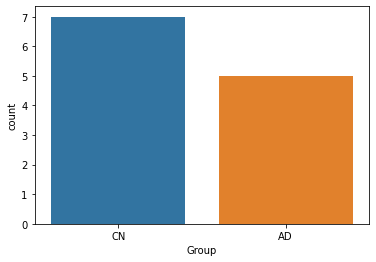

In [17]:
# see how balanced is the data
sns.countplot(x = 'Group', data=df)

In [18]:
# assign 0 and 1 to the NC and AD subjects respectively as labels
df['Group'] = df['Group'].astype('category')
encode_map = {
    'AD': 1,
    'CN': 0
}

df['Group'].replace(encode_map, inplace=True)

# Dataset

In [19]:
# CONSTANTS
# the address for predicted images for 70 epochs
IMAGES_PATH = '/content/drive/My Drive/ADNI_2_400_12_subjects/ADNI/T1/model/pred_images/'

In [20]:
# define the object of teh dataset for the training and validation 
class AdCNDataset(torch.utils.data.Dataset):
    def __init__(self, paths, labels):
        self.paths = paths
        self.labels = labels
        
        
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        file_path = self.paths[idx]
        label = self.labels[idx]
        im = cv2.imread(file_path, 1)
        data = {
                    'image': torch.FloatTensor(im),
                    'label' : label
                }
        return data

In [22]:
# create a dictionary to return images and their corresponding labels 
def createDatasetDictionary(images_path, df):
  image_paths = []
  labels = []
  for file in os.listdir(images_path):
      # extract the subject id from the image file name
      subject_id_raw = file[-11:-4]
      # extract the subject id from the image path
      subject_id = subject_id_raw[0:3] + '_S_' + subject_id_raw[3:]
      # find label
      subj_label = df.loc[df['Subject'] == subject_id, 'Group'].iloc[0]
      # append the image and labels to the lists
      image_paths.append(os.path.join(IMAGES_PATH, file)) 
      labels.append(subj_label)

  return image_paths, labels


# **Data Split**

In [23]:
# total number of observations for prediction
image_paths, labels = createDatasetDictionary(IMAGES_PATH, df)
len(image_paths)

/content/drive/My Drive/ADNI_2_400_12_subjects/ADNI/T1/model/pred_images/


107

In [24]:
# split data into training and validation with 70-30 proportions 
split_size = round(len(image_paths) * 0.7)
start_indx = random.randint(0, 40)
training_X = image_paths[start_indx:start_indx + split_size+1]
training_Y = labels[start_indx:start_indx + split_size+1]
print(len(training_X))
print(len(training_Y))
test_X = image_paths[0:start_indx] + image_paths[start_indx + split_size + 1: len(image_paths)]
test_Y = labels[0:start_indx] + labels[start_indx + split_size + 1: len(labels)]
print(len(test_X))
print(len(test_Y))


76
76
31
31


# Training 

In [25]:
import os

# CONSTANTS
LR = 0.001

INPUT_WIDTH = 224
INPUT_HEIGHT = 224

OUTPUT_WIDTH = 256
OUTPUT_HEIGHT = 256

NUM_CLASSES = 2
NUM_WORKERS = 6
BATCH_SIZE = 4

epochs = 100

MODEL_DIRECTORY = '/content/drive/My Drive/ADNI_2_400_12_subjects/ADNI/T1/ADCNModel'

# load model
model =  CNN_AD_CN(in_channels=3, out_channels=2)

# create DataSet object
train_set = AdCNDataset(training_X, training_Y)

# optimization and criterion
opt = optim.Adam(model.parameters(), lr=LR)
criterion = nn.BCEWithLogitsLoss()

# create data loader
train_loader = torch.utils.data.DataLoader(dataset=train_set,
                          batch_size=BATCH_SIZE,
                          shuffle=True,   
                          num_workers= NUM_WORKERS) 







In [ ]:
model.train()
is_better = True
prev_loss = float('inf')
batch_losses = []
epoch_losses = []
epoch_accuracy = []

for epoch in range(1, epochs+1):
        epoch_acc = 0
        loss_f = 0
        t_start = time.time()
        print('EPOCH @@@@@@@@@@@@@@: ', epoch)
        print('t_start:  %%%%%%%%: ', t_start)

        for batch in train_loader:   
            # Get the inputs; data is a list of [inputs, labels]
            input_tensor = torch.autograd.Variable(batch['image'])
            input_tensor = input_tensor.permute(0,3,2,1)
            target_tensor = torch.autograd.Variable(batch['label'])
            
            # fit model
            # Initialise gradients
            opt.zero_grad()
            # (1) Forward
            y_hat = model(input_tensor)
            # (2) Compute diff (loss and accuracy)
            y_pred_tag = torch.log_softmax(y_hat, dim = 1)
            _, y_pred_tags = torch.max(y_pred_tag, dim = 1)
            floated_pred_tensor = y_pred_tags.type(torch.FloatTensor)
            target_tensor = target_tensor.type(torch.FloatTensor)
            loss = criterion(floated_pred_tensor, target_tensor)
            acc = binary_acc(floated_pred_tensor, target_tensor)
            # (3) Compute gradients
            loss.backward()
            # (4) update weights
            opt.step()

            # add the batch loss for later reference
            batch_losses.append(loss.data.numpy())
            loss_f += loss.item()
            epoch_acc += acc.item()
            

        # calculate loss and accuracy for each epoch
        delta = time.time() - t_start
        ep_loss = loss_f/len(train_loader)
        ep_acc = epoch_acc/len(train_loader)
        is_better = ep_loss < prev_loss
        #print('loss_f == ', ep_loss)
        #print('epoch_acc == ', ep_acc)
        
        
        epoch_losses.append(ep_loss)  
        epoch_accuracy.append(ep_acc)

        if is_better:
            prev_loss = ep_loss
            torch.save(model.state_dict(), os.path.join(MODEL_DIRECTORY, "model_best_3.pth")) 
            # model_best_3.pth  for 100 epochs, lr=0.001 for the predicted images on the 'tests' set
            # model_best_4.pth  for 50 epochs, 50 batches, lr=0.001        
        print("Epoch #{} | tLoss: {} | tAccuracy: {} |  Time: {}s".format(epoch+1, ep_loss, ep_acc, delta))

print('epoch_loss_F == ', epoch_losses)
print('epoch_acc_F == ', epoch_accuracy)

In [ ]:
#https://towardsdatascience.com/pytorch-tabular-binary-classification-a0368da5bb89
def binary_acc(y_pred, y_test):
    correct_results_sum = (y_pred == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

## Plotting Training Accuracy and Loss

average accuracy ==  61.55199999999998
average loss ==  0.6956196769475941


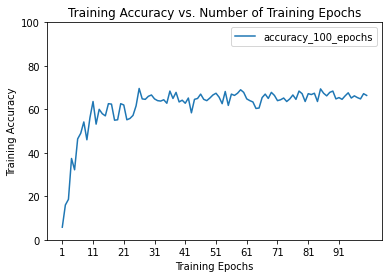

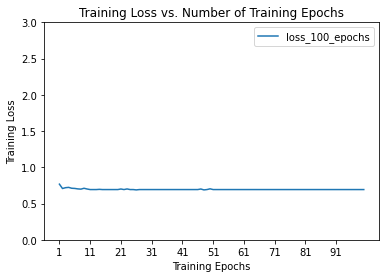

In [ ]:

#### TESTS SET ####
# accuracy on 100 epochs 
acc_list = [5.8, 16.0, 18.6, 37.4, 32.2, 46.4, 49.0, 54.2, 46.0, 56.2, 63.6, 53.2, 60.0, 58.0, 57.0, 62.6, 62.4, 55.0, 55.2, 62.6, 62.0, 55.2, 55.8, 57.2, 61.6, 69.6, 64.8, 64.6, 66.0, 66.6, 64.8, 64.0, 63.8, 64.4, 62.8, 68.4, 65.0, 67.8, 63.4, 64.2, 62.8, 65.2, 58.4, 64.6, 65.0, 67.0, 64.6, 64.0, 65.2, 66.6, 67.4, 65.6, 62.6, 68.2, 61.8, 67.0, 66.4, 67.4, 69.0, 67.8, 64.8, 64.0, 63.4, 60.4, 60.6, 65.4, 67.0, 65.0, 67.8, 66.4, 64.0, 64.4, 65.2, 63.6, 64.8, 66.6, 64.6, 68.4, 67.2, 63.6, 67.2, 66.8, 67.4, 63.6, 69.4, 67.4, 66.2, 67.8, 68.4, 64.8, 65.4, 64.6, 66.2, 67.6, 65.2, 66.2, 65.4, 64.8, 67.2, 66.4]
# loss on 100 epochs
loss_list = [0.7676748394966125, 0.7076699614524842, 0.7190650105476379, 0.7233255267143249, 0.7112351179122924, 0.7086485147476196, 0.7022177815437317, 0.6991529703140259, 0.7110320687294006, 0.7008985877037048, 0.6931459665298462, 0.6931487798690796, 0.6931472778320312, 0.6961506843566895, 0.6931472778320312, 0.693146800994873, 0.6931472778320312, 0.6931475400924683, 0.6931472778320312, 0.6931472778320312, 0.7008950233459472, 0.6931472778320312, 0.7016934871673584, 0.6931472778320312, 0.6931953668594361, 0.6883986949920654, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.6931473016738892, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.7008987188339233, 0.6883987069129944, 0.6931479454040528, 0.7033809661865235, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.6931614518165589, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.6931472539901733, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.693091344833374, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312, 0.6931472778320312]

print('average accuracy == ', sum(acc_list)/len(acc_list))
print('average loss == ', sum(loss_list)/len(loss_list))


plt.close()
# plot acccuracy
plt.title("Training Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Training Accuracy")
plt.plot(range(1,epochs+1),acc_list,label="accuracy_100_epochs")
plt.ylim((0,100.))
plt.xticks(np.arange(1, epochs+1, 10.0))
plt.legend()
plt.show()

# plot loss
plt.title("Training Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Training Loss")
plt.plot(range(1,epochs+1),loss_list,label="loss_100_epochs")
plt.ylim((0,3.))
plt.xticks(np.arange(1, epochs+1, 10.0))
plt.legend()
plt.show()

# Validation

In [26]:
# validation function
def validate(val_dataloader, model, OUTPUT_DIR):
    y_pred_list = []

    model.eval()
    loss_f = 0
    acc_f = 0
    
    print('size of each prediction batch:', len(val_dataloader))
    for batch_idx, batch in enumerate(val_dataloader):
        print("batch inde ==== ", batch_idx)
        input_tensor = torch.autograd.Variable(batch['image'])
        input_tensor = input_tensor.permute(0,3,2,1)
        target_tensor = torch.autograd.Variable(batch['label'])
        target_tensor = torch.unsqueeze(target_tensor, 1)
       
        # fit model
        predicted_tensor = model(input_tensor)
        # calculate loss and accuracy for each batch
        loss = criterion(predicted_tensor, target_tensor.float())
        acc = binary_acc(predicted_tensor, target_tensor.float())
        #print('loss:', loss)
        #print('accuracy:', acc)
        loss_f += loss
        acc_f += acc
        y_pred_tag = torch.round(predicted_tensor)
        y_pred_list.append(y_pred_tag.cpu().detach().numpy())

    # final loss and accuracy
    final_loss = loss_f/len(val_dataloader)
    final_acc = acc_f/len(val_dataloader)
    #print('final_loss == ', final_loss)
    #print('final_accuracy == ', final_acc)

    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
  
    return y_pred_list


        



In [ ]:

import os
import matplotlib.image as pltimage


# constants
NUM_BACHES = 1
LR = 0.001
NUM_WORKERS = 4


INPUT_WIDTH = 224
INPUT_HEIGHT = 224


# path for the saved best model from training
SAVED_MODEL_PATH = os.path.join(MODEL_DIRECTORY, "model_best_3.pth")

# create output directory
OUTPUT_DIR = os.path.join(MODEL_DIRECTORY, "predictions")
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# validation Dataset
val_dataset = AdCNDataset(test_X, test_Y)

# create data loader
val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset,
                          batch_size=NUM_BACHES,
                          shuffle=True,   
                          num_workers= NUM_WORKERS)

# load model
model =  CNN_AD_CN(in_channels=3, out_channels=2)
# criterian
criterion = nn.BCEWithLogitsLoss()
# load model into the temp
model.load_state_dict(torch.load(SAVED_MODEL_PATH))




<All keys matched successfully>

In [ ]:
# call on validate function
y_pred_list = validate(val_dataloader, model, OUTPUT_DIR)

## Classification Report

In [ ]:
# classification report
test_Y_arr = np.array(test_Y)
y_pred_list_arr = np.array(y_pred_list)
print(classification_report(test_Y_arr, y_pred_list_arr, zero_division="warn"))

              precision    recall  f1-score   support

           0       0.65      1.00      0.78        20
           1       0.00      0.00      0.00        11

    accuracy                           0.65        31
   macro avg       0.32      0.50      0.39        31
weighted avg       0.42      0.65      0.51        31



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
